# Test MDRNN Training on differential data by Overfitting

In this notebook, we will try to train the MDRNN on a single example to see if we can get it to overfit. Hopefully we can debug the model a bit this way.

### First Import the Model and Tensorflow

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
# little path hack to get robojam from one directory up in the filesystem.
from context import * # imports robojam
# import robojam # alternatively do this.
import tensorflow as tf
import h5py
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

input_colour = 'darkblue'
gen_colour = 'firebrick'
plt.style.use('seaborn-talk')

In [119]:
def divide_performance_into_swipes(perf_df):
    """Divides a performance into a sequence of swipe dataframes for plotting."""
    touch_starts = perf_df[perf_df.moving == 0].index
    performance_swipes = []
    remainder = perf_df
    for att in touch_starts:
        swipe = remainder.iloc[remainder.index < att]
        performance_swipes.append(swipe)
        remainder = remainder.iloc[remainder.index >= att]
    performance_swipes.append(remainder)
    return performance_swipes

def plot_2D(perf_df, name="foo", saving=False):
    """Plot a 2D representation of a performance 2D"""
    swipes = divide_performance_into_swipes(perf_df)
    plt.figure(figsize=(8, 8))
    for swipe in swipes:
        p = plt.plot(swipe.x, swipe.y, 'o-')
        plt.setp(p, color=gen_colour, linewidth=5.0)
    plt.ylim(1.0,0)
    plt.xlim(0,1.0)
    plt.xticks([])
    plt.yticks([])
    if saving:
        plt.savefig(name+".png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()
        
def generate_performance(net, first_touch, number, sess, temp=1.0):
    """Special version of generate performance for sampling during training - differential version."""
    previous_touch = (0, 0, 0) # not using the first touch point here.
    performance = [previous_touch.reshape((net.n_input_units,))]
    for i in range(number):
        touch_diff = net.generate_touch(previous_touch, sess, temp=temp)
        previous_touch = previous_touch + touch_diff
        performance.append(previous_touch.reshape((net.n_input_units,)))
    generated = np.array(performance)
    summed = diff_to_normal_perf(generated, first_touch) # convert to normal performance format.
    return summed

def generate_performance(net, first_touch, number, sess, temp=1.0):
    """Special version of generate performance for sampling during training."""
    previous_touch = np.array([0, 0, first_touch[2]])
    # np.array([np.random.rand(), np.random.rand(), 0.01])
    performance = [previous_touch.reshape((net.n_input_units,))]
    for i in range(number):
        previous_touch = net.generate_touch(previous_touch, sess, temp=temp)
        performance.append(previous_touch.reshape((net.n_input_units,)))
    return np.array(performance)

def diff_to_normal_perf(perf, first_touch):
    """Adds up XY points in a differential performance to produce a normal one. Operates on ndarrays."""
    first_xy = first_touch[[0,1]]
    t = perf.T[2]
    xy = perf.T[[0,1]]
    xy_summed = (np.cumsum(xy, axis=1) + (np.ones((257,2)) * first_xy).T)
    return np.append(xy_summed, np.array([t]), axis=0).T

def normal_to_diff_perf(perf):
    """Diffs the XY columns in a normal performance to produce a differential one. Operates on ndarrays."""
    t = perf.T[2]
    xy = perf.T[[0,1]]
    xy_diff = np.diff(xy)
    xy_diff = np.insert(xy_diff, 0, [0,0], axis=1)
    return np.append(xy_diff, np.array([t]), axis=0).T 

In [112]:
# Training Hyperparameters:
SEQ_LEN = 256
BATCH_SIZE = 1
HIDDEN_UNITS = 256
LAYERS = 3
MIXES = 16
EPOCHS = 1000

# These settings train for 2.1 epochs which is pretty good!
SEED = 2345  # 2345 seems to be good.

random.seed(SEED)
np.random.seed(SEED)
# tf.set_random_seed(5791)  # only works for current graph.

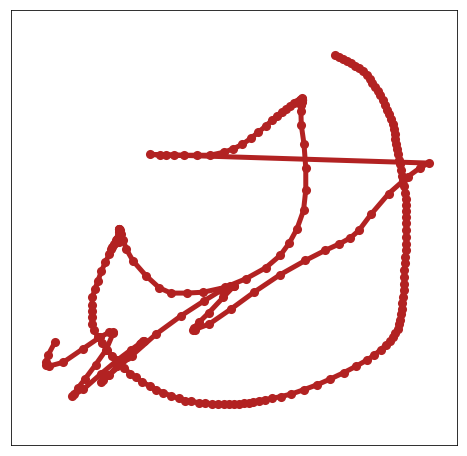

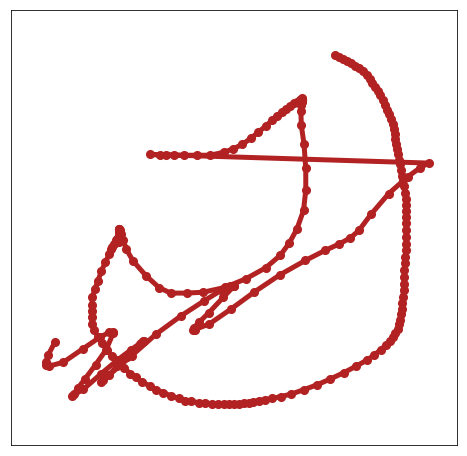

In [113]:
# Testing diff performance converters.
diffed = normal_to_diff_perf(overfit_datum)
summed = diff_to_normal_perf(diffed, start_point)

plot_2D(robojam.perf_array_to_df(overfit_datum))
plot_2D(robojam.perf_array_to_df(summed))

0.017112

Total training examples: 172003
Done initialising loader.
Total non-overlapping examples: 670
Shape of Overfit Batch: (1, 1, 257, 3)
Start Point: [ 0.099       0.76300001  0.017112  ]
Input Data:


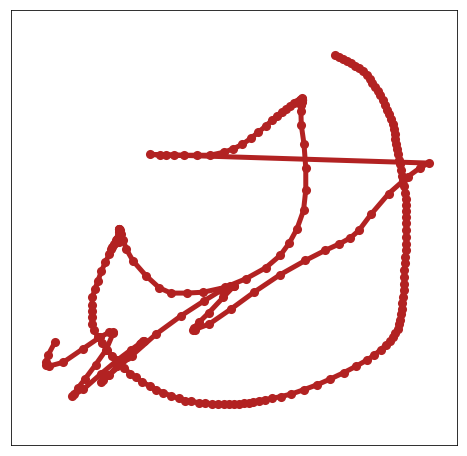

Loading Network
INFO:tensorflow:Loading Training Operations


INFO:tensorflow:Loading Training Operations


INFO:tensorflow:done initialising: mdrnn-2d-1d-3layers-256units-16mixtures vars: 1353872


INFO:tensorflow:done initialising: mdrnn-2d-1d-3layers-256units-16mixtures vars: 1353872


In [114]:
microjam_data_file_name = "../datasets/TinyPerformanceCorpus.h5"
metatone_data_file_name = "../datasets/MetatoneTinyPerformanceRecords.h5"

with h5py.File(microjam_data_file_name, 'r') as data_file:
    microjam_corpus = data_file['total_performances'][:]
with h5py.File(metatone_data_file_name, 'r') as data_file:
    metatone_corpus = data_file['total_performances'][:]

sequence_loader = robojam.sample_data.SequenceDataLoader(num_steps=SEQ_LEN + 1, batch_size=BATCH_SIZE, corpus=microjam_corpus)
examples = sequence_loader.non_overlapping_examples()
overfit_datum = examples[3]  # picked a sample
overfit_start_point = overfit_datum[0]
diffed_overfit_datum = normal_to_diff_perf(overfit_datum) # going to train on the diffed data.
overfit_batch = np.array([[diffed_overfit_datum]])
print("Shape of Overfit Batch:", overfit_batch.shape)
print("Start Point:", start_point)
print("Input Data:")
plot_2D(robojam.perf_array_to_df(overfit_datum))


print("Loading Network")
# Setup network
net = robojam.MixtureRNN(mode=robojam.NET_MODE_TRAIN, 
                         n_hidden_units=HIDDEN_UNITS, 
                         n_mixtures=MIXES, 
                         batch_size=BATCH_SIZE, 
                         sequence_length=SEQ_LEN, 
                         n_layers=LAYERS)

In [131]:
x = 220
overfit_batch[:,:,x:x+30,:]

print(overfit_batch[:,:,0,:])

print(overfit_start_point)

#pd.DataFrame(overfit_batch)

[[[ 0.        0.        0.017112]]]
[ 0.099       0.76300001  0.017112  ]


Training Network: mdrnn-2d-1d-3layers-256units-16mixtures
INFO:tensorflow:going to train: mdrnn-2d-1d-3layers-256units-16mixtures


INFO:tensorflow:going to train: mdrnn-2d-1d-3layers-256units-16mixtures


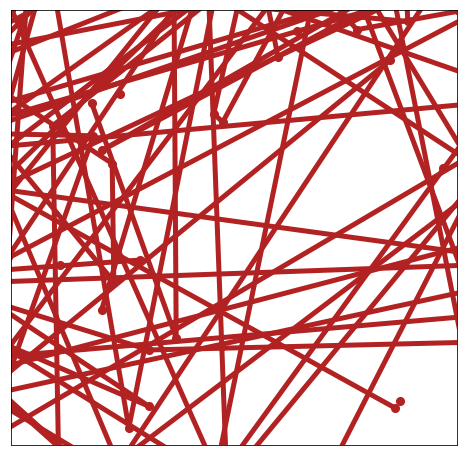

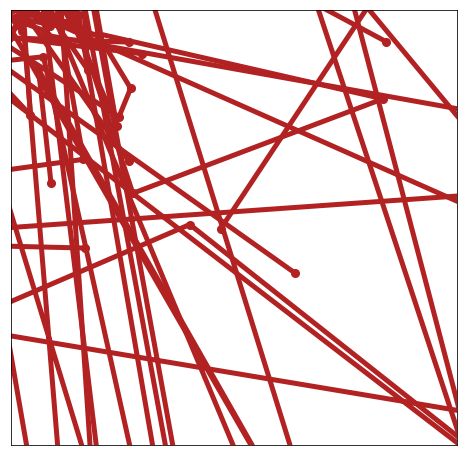

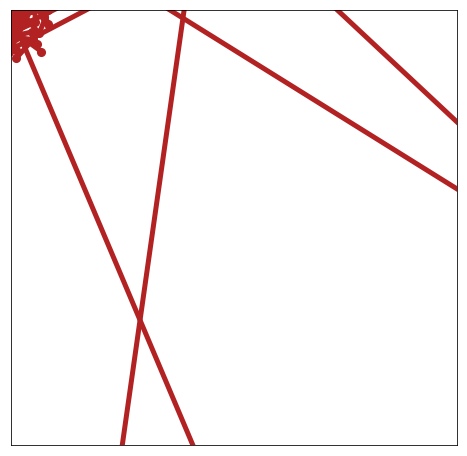

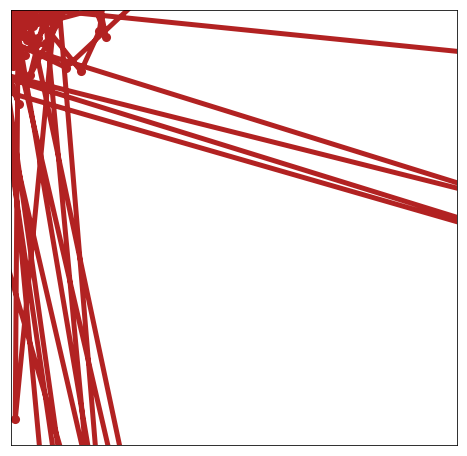

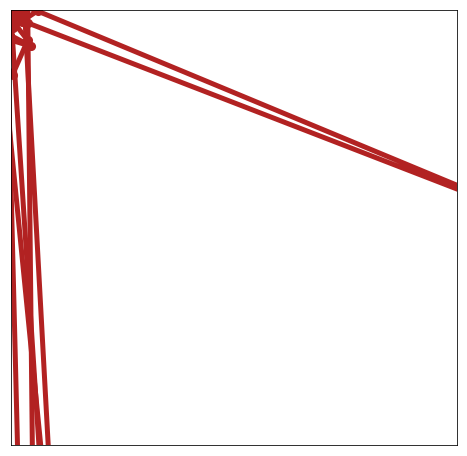

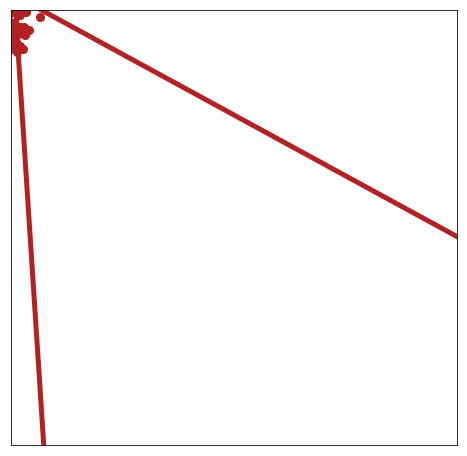

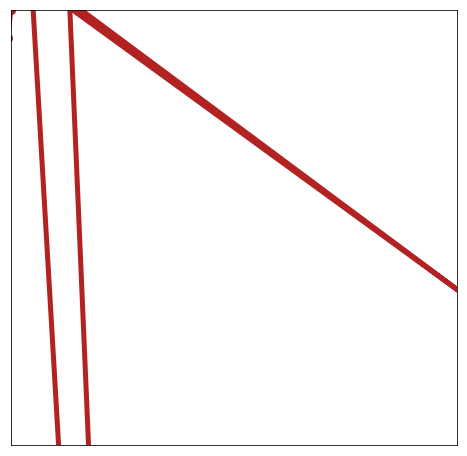

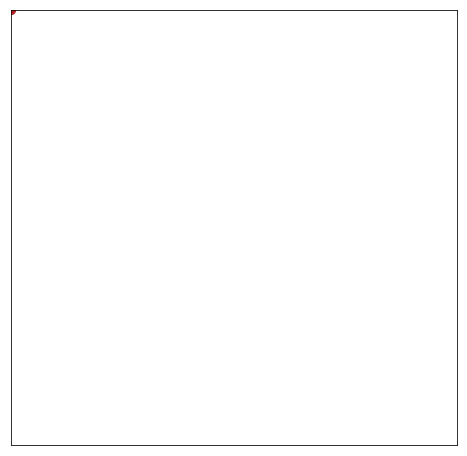

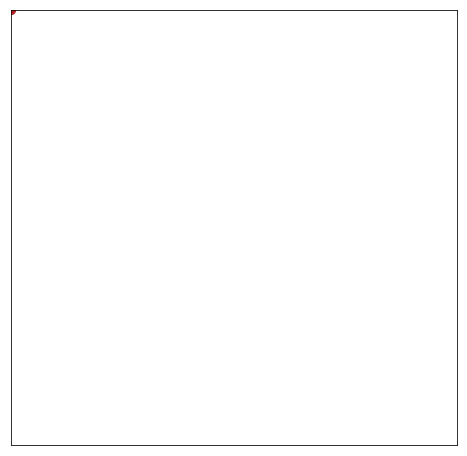

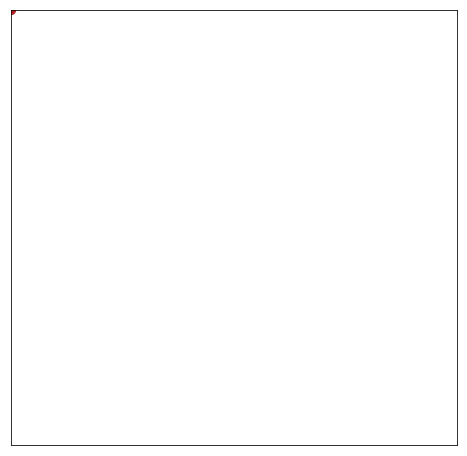

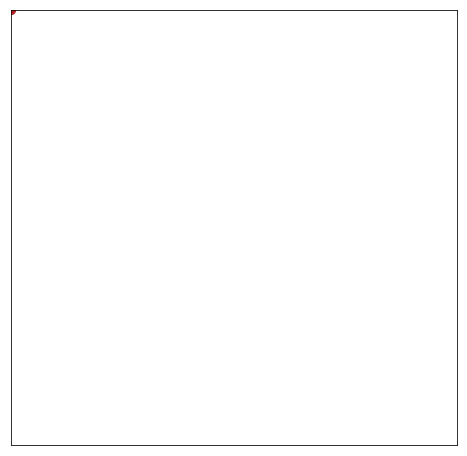

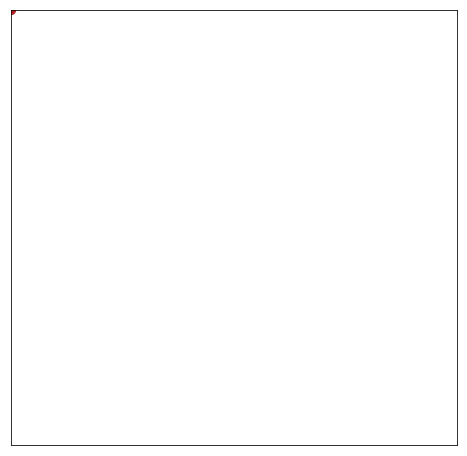

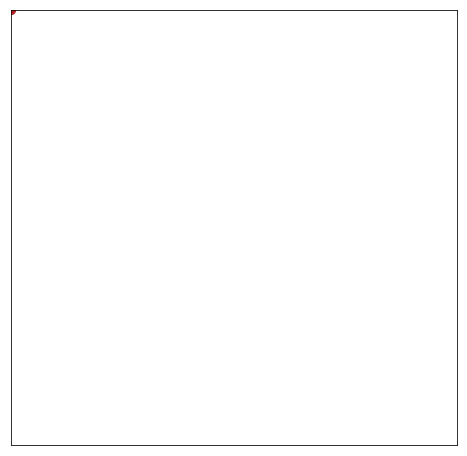

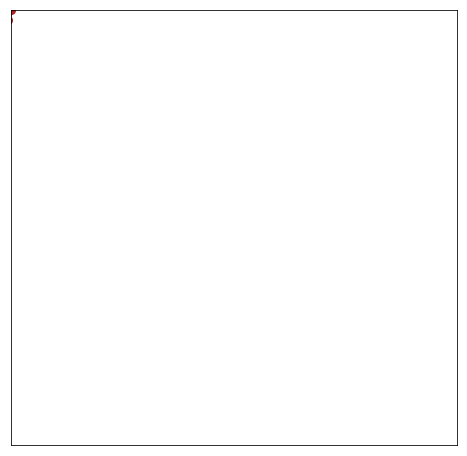

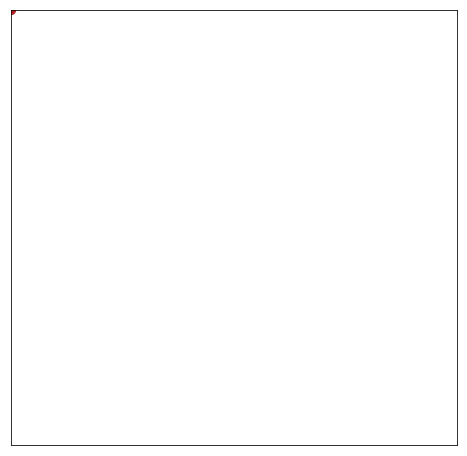

ValueError: sum(pvals[:-1]) > 1.0

In [120]:
# load metatone data and train MDRNN from that.
print("Training Network:", net.model_name())
# # Train
# losses = net.train(sequence_loader, EPOCHS, saving=True)
# print(losses)

"""Train the network for the a number of epochs."""
num_epochs = 10000
tf.logging.info("going to train: %s", net.model_name())
start_time = time.time()
training_losses = []

step = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(num_epochs):
        batches = overfit_batch
        # try training, stop if there is a value error (NaN in loss).
        try:
            epoch_average_loss, step = net.train_epoch(batches, sess)
        except ValueError as err:
            tf.logging.info("training was aborted due to value error at global_step %d, epoch %d", step, i)
            tf.logging.info(err.args)
            break
        training_losses.append(epoch_average_loss)
        print("trained epoch %d of %d. Loss was: %f" % (i, num_epochs, epoch_average_loss), end="\r")
        if i % 100 is 0:
            output = generate_performance(net, overfit_start_point, 256, sess, temp=1.0)
            plot_2D(robojam.perf_array_to_df(output))
tf.logging.info("took %d seconds to train.", (time.time() - start_time))
training_losses

print("Done")

# Save weights.

#     if saving:
#         # Save finished model separately.
#         tf.logging.info('saving model %s.', net.model_name())
#         net.saver.save(sess, MODEL_DIR + net.model_name())

# Generate a performance from starting point:

# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     output = generate_performance(net, start_point, 256, sess, temp=0.5)
# plot_2D(robojam.perf_array_to_df(output))

In [ ]:
# Have a look at the loss during training.

df = pd.DataFrame({"loss":training_losses})
df.plot()